In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [2]:
lc_u2=np.load('uid_per_shb_fatigue(1).npy')

In [3]:
value_types = pd.read_csv('epoch_value_types.csv')
value_types = value_types.rename(columns={"id": "type"})

In [4]:
def add_s(st, end):
    
    if st == end:
        end += pd.Timedelta(seconds=1)
    return end

In [5]:
def clean_endv(st, end):
    if end == pd.Timestamp('1970-01-01 00:00:00'):
        end = st
    return end

In [6]:
def get_epoch(user_ids):
     
    ft = tuple(user_ids)    
    us_data = query_ch_df(
        """SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {}""".format(ft)   )
    
    us_data = pd.merge(us_data, value_types, on='type')
    us_data = us_data.drop(columns=['type'])
    us_data = us_data.rename(columns={"code": "type"})
    us_data.startTimestamp = us_data.startTimestamp//1000
    us_data.endTimestamp = us_data.endTimestamp//1000
    us_data.startTimestamp = us_data.startTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    us_data.endTimestamp = us_data.endTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
    us_data.endTimestamp  = us_data.apply(lambda x: clean_endv(x.startTimestamp, x.endTimestamp),axis=1)
    us_data.endTimestamp  = us_data.apply(lambda x: add_s(x.startTimestamp, x.endTimestamp),axis=1)
    us_data = us_data.rename(columns={"startTimestamp": "start", "endTimestamp": "end"})
    us_data = us_data.rename(columns={"customer": "id"})
    
    return us_data

In [7]:
# get age
def get_demo(user_ids):
    
    if isinstance(user_ids, int) or isinstance(user_ids, np.int64):
        formatter = f'({user_ids})'
    elif len(user_ids) == 1:
        formatter = f'({user_ids[0]})'
    else:
        formatter = tuple(user_ids) 
 
    query = f"""
    SELECT 
        user_id, salutation, birth_date, weight, height, creation_timestamp
    FROM 
        rocs.datenspende.users
    WHERE 
        users.user_id IN {formatter} 
    """ 

    users = query_pg_df(query)
    users.creation_timestamp = pd.to_datetime(users['creation_timestamp'],unit='ms') 
    users.creation_timestamp = users.creation_timestamp.dt.date
    users['age'] = np.floor((2023 + 1 / 12) - users['birth_date'] + 2.5)

    return users

In [8]:
def get_sex(user_ids):
 
    if isinstance(user_ids, int) or isinstance(user_ids, np.int64):
        formatter = f'({user_ids})'
    elif len(user_ids) == 1:
        formatter = f'({user_ids[0]})'
    else:
        formatter = tuple(user_ids)

    qu = f"""
    select    
        a.user_id,
        a.created_at,
        a.question,
        a.element        
    from 
        rocs.datenspende.answers a
    where 
        a.user_id IN {formatter}
    AND
        a.question = 127    
    """
    users = query_pg_df(qu)
    users.created_at = pd.to_datetime(users['created_at'],unit='ms')
    users.created_at = users.created_at.dt.date

    return users

In [26]:
# this method takes all the users epoch data and puts it into bin_size_in_min bins of hr / steps data
# data explanation
# user_data is a dataframe for a single user, single source, HR + steps data
# columns
# id: user id
# longValue: HR in bpm
# doubleValue: steps [count]
# type: either "HeartRate" or "Steps"
# start: datetime start epoch
# end: datetime end epoch
# source: data source
# 
#      type source  doubleValue  longValue               id               start                 end
# HeartRate Fitbit          NaN       98.0       1234567890 2022-05-28 15:22:26 2022-05-28 15:41:13
#     Steps Fitbit       1526.0        NaN       1234567890 2022-05-28 15:22:26 2022-05-28 15:41:13
# HeartRate Fitbit          NaN      104.0       1234567890 2022-05-28 17:57:00 2022-05-28 19:31:47
#     Steps Fitbit       9269.0        NaN       1234567890 2022-05-28 17:57:00 2022-05-28 19:31:47
# HeartRate Fitbit          NaN      105.0       1234567890 2022-05-28 22:15:43 2022-05-28 22:40:30
def resample(us_data, bin_size_in_min):
    
        
    if len(us_data.index) > 50:
        
        user_data = us_data.copy()
        user_data = user_data[['id', 'doubleValue', 'longValue', 'booleanValue', 'start', 'end', 'source', 'type']]
        user_data.rename(
            columns={"longValue": "hr", "doubleValue": "steps", "booleanValue": "sleep"}, inplace=True
        )
        user_data["duration"] = (user_data.end - user_data.start) / pd.Timedelta(
            "1 sec"
        )
        user_data.reset_index(drop=True, inplace=True)
        
        add_values = user_data[(user_data.duration > 1)&(user_data.type == 'Steps')]

        new_values = []
        for idx, row in add_values.iterrows():
            for i in np.arange(0, row.duration, 1):
                end_time = min(
                    row.end,
                    row.start
                    + pd.Timedelta("%d sec" % i)
                    + pd.Timedelta("%d sec" % 1),
                )
                new_duration = (
                    end_time - (row.start + pd.Timedelta("%d sec" % i))
                ) / pd.Timedelta("1 sec")
                new_values.append([
                    
                    row.id,
                    (row.steps / (row.duration / new_duration)),
                    row.hr,
                    row.sleep,
                    row.start + pd.Timedelta("%d sec" % i),
                    end_time,
                    row.source,
                    row.type,
                    new_duration,
                ])
        steps = user_data[(user_data.duration <= 1)&(user_data.type == 'Steps')].append(pd.DataFrame(data=new_values, columns=user_data.columns))
        steps = steps.sort_values(by='start')
        steps = steps.groupby(['start','type']).mean().reset_index()
        df = user_data[user_data.type != 'Steps'].append(steps)
        
        add_values = user_data[(user_data.duration > 60)]

        new_values = []
        for idx, row in add_values.iterrows():
            for i in np.arange(0, row.duration, 60):
                end_time = min(
                    row.end,
                    row.start
                    + pd.Timedelta("%d sec" % i)
                    + pd.Timedelta("%d sec" % 60),
                )
                new_duration = (
                    end_time - (row.start + pd.Timedelta("%d sec" % i))
                ) / pd.Timedelta("1 sec")
                new_values.append([
                    
                    row.id,
                    (row.steps / (row.duration / new_duration)),
                    row.hr,
                    row.sleep,
                    row.start + pd.Timedelta("%d sec" % i),
                    end_time,
                    row.source,
                    row.type,
                    new_duration,
                ])
                
        df = user_data[user_data.duration <= 60].append(pd.DataFrame(data=new_values, columns=user_data.columns))
        df = df.sort_values(by='start')
        df = df.groupby(['start','type']).mean().reset_index()
        
        heartrate_bin = (
            df[df.type == "HeartRate"][["start", "hr"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["hr"])
        heartrate_bin["source"] = df.source.unique()[0]
        heartrate_bin["id"] = df.id.unique()[0]
      
        restheartrate_bin = (
            df[df.type == "HeartRateRestingHourly"][["start",  "hr"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["hr"])
       
        restheartrate_bin = restheartrate_bin.rename(columns={"hr": "rhr"})
  
        sleep_bin = (
            df[df.type == "SleepStateBinary"][["start",  "sleep"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["sleep"])

        steps_bin = (
            user_data[user_data.type == "Steps"][["start",  "steps"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .sum()
            .reset_index()
        ).dropna(subset=["steps"])     

        data_frames = [heartrate_bin, restheartrate_bin, sleep_bin, steps_bin]
        df_lc = reduce(lambda  left,right: pd.merge(left,right,on=['start'],
                                                    how='outer'), data_frames)
        return df_lc
    return 

In [27]:
    us_id = lc_u2[77]
    gs = get_sex([us_id])
    ag = get_demo([us_id])
    if len(gs) > 0:
        sex = 'female' if gs['element'].values[0] == 773 else 'male'
    else: 
        sex = 'nd'
    if len(ag) > 0:
        age = ag['age'].values[0]
    else:
        age = 'nd'

    ud = get_epoch([us_id])

/home/jovyan/datenspende-science/datenspende/utils/load_from_postgres.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
/home/jovyan/datenspende-science/datenspende/utils/load_from_postgres.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [31]:
ud[ud.type == 'SPO2']

,id,valueType,doubleValue,longValue,booleanValue,timezoneOffset,start,end,createdAt,source,type
1426371,1116926,0,100.0,NaN,NaN,60,2022-01-12 21:24:00,2022-01-12 21:59:00,1642119931269,3,SPO2
1426372,1116926,0,98.0,NaN,NaN,60,2022-01-12 21:59:00,2022-01-12 22:00:00,1642119931269,3,SPO2
1426373,1116926,0,92.0,NaN,NaN,60,2022-01-12 22:00:00,2022-01-12 22:01:00,1642119931269,3,SPO2
1426374,1116926,0,91.0,NaN,NaN,60,2022-01-12 22:01:00,2022-01-12 22:02:00,1642119931269,3,SPO2
1426375,1116926,0,92.0,NaN,NaN,60,2022-01-12 22:02:00,2022-01-12 22:04:00,1642119931269,3,SPO2
...,...,...,...,...,...,...,...,...,...,...,...
1430652,1116926,0,92.0,NaN,NaN,60,2022-01-28 04:51:00,2022-01-28 04:52:00,1643434798015,3,SPO2
1430653,1116926,0,94.0,NaN,NaN,60,2022-01-28 04:52:00,2022-01-28 04:55:00,1643434798015,3,SPO2
1430654,1116926,0,92.0,NaN,NaN,60,2022-01-28 04:55:00,2022-01-28 04:56:00,1643434798015,3,SPO2
1430655,1116926,0,93.0,NaN,NaN,60,2022-01-28 04:56:00,2022-01-28 05:00:00,1643434798015,3,SPO2


In [32]:
bin_size_in_min = 60

In [34]:
us_data = ud.copy()

In [35]:
        user_data = us_data.copy()
        user_data = user_data[['id', 'doubleValue', 'longValue', 'booleanValue', 'start', 'end', 'source', 'type']]
        user_data.rename(
            columns={"longValue": "hr", "doubleValue": "steps", "booleanValue": "sleep"}, inplace=True
        )
        user_data["duration"] = (user_data.end - user_data.start) / pd.Timedelta(
            "1 sec"
        )
        user_data.reset_index(drop=True, inplace=True)
        
        add_values = user_data[(user_data.duration > 1)&(user_data.type == 'Steps')]

        new_values = []
        for idx, row in add_values.iterrows():
            for i in np.arange(0, row.duration, 1):
                end_time = min(
                    row.end,
                    row.start
                    + pd.Timedelta("%d sec" % i)
                    + pd.Timedelta("%d sec" % 1),
                )
                new_duration = (
                    end_time - (row.start + pd.Timedelta("%d sec" % i))
                ) / pd.Timedelta("1 sec")
                new_values.append([
                    
                    row.id,
                    (row.steps / (row.duration / new_duration)),
                    row.hr,
                    row.sleep,
                    row.start + pd.Timedelta("%d sec" % i),
                    end_time,
                    row.source,
                    row.type,
                    new_duration,
                ])
        steps = user_data[(user_data.duration <= 1)&(user_data.type == 'Steps')].append(pd.DataFrame(data=new_values, columns=user_data.columns))
        steps = steps.sort_values(by='start')
        steps = steps.groupby(['start','type']).mean().reset_index()
        df = user_data[user_data.type != 'Steps'].append(steps)
        
        add_values = user_data[(user_data.duration > 60)]

        new_values = []
        for idx, row in add_values.iterrows():
            for i in np.arange(0, row.duration, 60):
                end_time = min(
                    row.end,
                    row.start
                    + pd.Timedelta("%d sec" % i)
                    + pd.Timedelta("%d sec" % 60),
                )
                new_duration = (
                    end_time - (row.start + pd.Timedelta("%d sec" % i))
                ) / pd.Timedelta("1 sec")
                new_values.append([
                    
                    row.id,
                    (row.steps / (row.duration / new_duration)),
                    row.hr,
                    row.sleep,
                    row.start + pd.Timedelta("%d sec" % i),
                    end_time,
                    row.source,
                    row.type,
                    new_duration,
                ])
                
        df = user_data[user_data.duration <= 60].append(pd.DataFrame(data=new_values, columns=user_data.columns))
        df = df.sort_values(by='start')
        df = df.groupby(['start','type']).mean().reset_index()
        
        heartrate_bin = (
            df[df.type == "HeartRate"][["start", "hr"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["hr"])
        heartrate_bin["source"] = df.source.unique()[0]
        heartrate_bin["id"] = df.id.unique()[0]
      
        restheartrate_bin = (
            df[df.type == "HeartRateRestingHourly"][["start",  "hr"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["hr"])
       
        restheartrate_bin = restheartrate_bin.rename(columns={"hr": "rhr"})
  
        sleep_bin = (
            df[df.type == "SleepStateBinary"][["start",  "sleep"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["sleep"])

        steps_bin = (
            user_data[user_data.type == "Steps"][["start",  "steps"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .sum()
            .reset_index()
        ).dropna(subset=["steps"])  
        
        spo_bin = (
            user_data[user_data.type == 'SPO2'][["start",  "steps"]]
            .set_index("start")
            .resample("%d Min" % bin_size_in_min)
            .mean()
            .reset_index()
        ).dropna(subset=["steps"])          

        data_frames = [heartrate_bin, restheartrate_bin, sleep_bin, steps_bin, spo_bin]
        df_lc = reduce(lambda  left,right: pd.merge(left,right,on=['start'],
                                                    how='outer'), data_frames)

In [36]:
def phases(week):
    if week < 0:
        ph = 0
    elif (week >= 0 and week <= 4):
        ph = 1
    elif (week >= 5 and week <= 12):
        ph = 2
    elif week > 12:
        ph = 3
    return ph

In [37]:
user = df_lc.copy()

In [39]:
pos_test = pd.read_csv('pos_testdate.csv',index_col=0)

In [40]:

        
    user['date'] = user.start.apply(lambda x: x.date())
    user['day_of_week'] = pd.to_datetime(user['date']).dt.dayofweek     
 
    user['weekend'] = user['day_of_week'].apply(lambda x: True if x >= 5 else False)

    user['dt'] = pd.to_datetime(pos_test['dt'][pos_test['user_id'].isin([us_id])].iloc[0])
    user['day_totest'] = pd.to_datetime(user['date']) - user['dt'] 
    user['week_totest'] = user['day_totest'].apply(lambda x: -(x.days// - 7))
    user['phase'] = user['week_totest'].apply(lambda x: phases(x))

    if sex == 'female':
        MHR = 206 - (0.88 * age)
    elif sex == 'male':
        MHR = 208 - (0.7 * age)
    else:
        
        MHR = np.nan

    user['% of MHR'] = (user['hr'])/ MHR * 100

     

In [41]:
d_agg = user.copy()

In [45]:
user['steps_y'].unique()

array([        nan, 99.        , 91.5       , 92.75      , 90.61363636,
       88.9375    , 90.4516129 , 91.92307692, 90.25      , 93.44117647,
       92.42857143, 91.14705882, 91.17073171, 91.41666667, 90.625     ,
       92.21052632, 90.76470588, 91.83333333, 91.66666667, 93.0952381 ,
       92.35135135, 91.85714286, 91.55555556, 93.71428571, 92.86363636,
       88.        , 92.03846154, 91.75      , 90.4       , 89.85      ,
       92.42307692, 91.91304348, 91.5625    , 90.19230769, 93.37931034,
       91.2972973 , 94.22857143, 93.15      , 90.16666667, 90.78947368,
       89.12121212, 92.        , 89.68421053, 90.11904762, 91.42857143,
       89.9       , 90.70731707, 91.16666667, 90.64      , 91.68181818,
       85.94117647, 89.48717949, 90.74418605, 91.65384615, 91.63333333,
       90.        , 91.        , 92.04545455, 93.        , 91.73809524,
       91.23255814, 90.3030303 , 89.39473684, 92.05      , 90.22857143,
       91.375     , 91.4       , 92.2       , 90.34482759, 89.29

KeyError: 'steps'

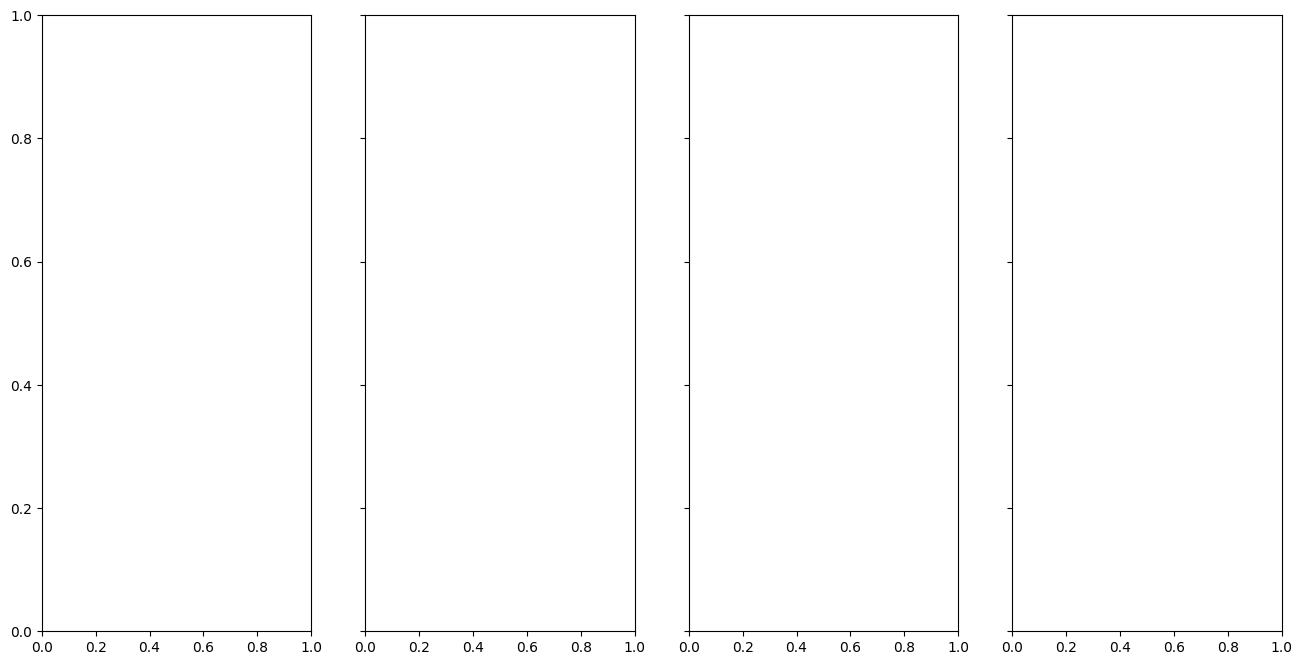

In [42]:
fig, ax = plt.subplots(1,4,figsize=(16,8),sharex = True, sharey = True)
for ph in [0,1,2,3]:
    dph = d_agg[d_agg['phase'] == ph]
    for dat in  dph['date'].unique():
        ax[ph].plot(dph[dph['date'] == dat]['steps'],dph[dph['date'] == dat]['hr'])
        x = dph[dph['date'] == dat]['steps'] -4
        y = dph[dph['date'] == dat]['hr']
        x= x.values
        y = y.values
        ax[ph].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],scale_units='xy',  angles='xy', scale=4,width=0.004)
        ax[ph].set_title(phases[ph])
        ax[ph].set_xlabel('steps')
        ax[ph].set_ylabel('hr');